In [ ]:
#importing all the necessary packages
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [ ]:
#Loading the dataset
#Loading 80% samples into training dataset and remaining 20% into test dataset
(train_ds, test_ds), ds_info = tfds.load(
    'malaria',
    #split = 'train',
    with_info = True,
    split=['train[:80%]','train[80%:]'], 
    as_supervised=True
)

In [ ]:
#Normalization
train_ds = train_ds.map(lambda image, label : (tf.image.per_image_standardization(image), label))
test_ds = test_ds.map(lambda image, label : (tf.image.per_image_standardization(image), label))
for image , label in test_ds.take(5):
  print(image.shape)
  print(label)

plots = tfds.show_examples(train_ds, ds_info)

In [ ]:
#resized_train_ds = train_ds.map(lambda image, label : (tf.image.resize(image, (60,60)), tf.one_hot(label, 1)))
resized_train_ds = train_ds.map(lambda image, label : (tf.image.resize_with_pad(image, 60,60), tf.one_hot(label, 1)))
#for image , label in resized_train_ds.take(9):
  #plt.imshow(np.uint8(image))
  #plt.title(image.shape)
  #plt.axis("off")
  #plt.show()

train_dataset = resized_train_ds.batch(64)
train_dataset = train_dataset.shuffle(buffer_size=128)

resized_test_ds = test_ds.map(lambda image, label :(tf.image.resize_with_pad(image, 60,60), tf.one_hot(label, 1)))
test_dataset = resized_test_ds.batch(64)
test_dataset = test_dataset.shuffle(buffer_size=128)

#caching 
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
#Constructing the network architecture
class Model(Layer): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        #Defining a 2D convolutional layer, with 32 kernels, each kernel is of the dim 3x3 
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               input_shape=(60,60,3)
                                               )
        #downsizing the sample by taking the max of the window size, i'm assuming that the default pool size is 2x2
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.drop_1 = tf.keras.layers.Dropout(0.2)
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.drop_2 = tf.keras.layers.Dropout(0.3)

        self.conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        #self.max_pool_3 = tf.keras.layers.MaxPool2D()
        #self.drop_3 = tf.keras.layers.Dropout(0.5)
        self.conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.drop_3 = tf.keras.layers.Dropout(0.5)
        #Convert the input to a 1D vector
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        #10 output units, with softmax activation function
        self.output_layer = tf.keras.layers.Dense(1,
                                                  activation=tf.keras.activations.sigmoid)


    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.drop_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.drop_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.max_pool_3(x)
        x = self.drop_3(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x


In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (image, label) in test_data:
    prediction = model(image)
    sample_test_loss = loss_function(label, prediction)
    #print(" printing label",label)
    #print("pred",prediction)
    #accuracy calc will change
    sample_test_accuracy =  np.argmax(label, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    #sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.MeanSquaredError(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
#test_loss,test_accuracy = test(model, test_dataset, binary_cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss,_ = test(model, train_dataset, binary_cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (image,label) in train_dataset:
        train_loss = train_step(model, image, label, binary_cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)
    #print("train_losses", train_losses)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    #print("test losses",test_losses )
    test_accuracies.append(test_accuracy)
    print("test losses",test_accuracies )



Epoch: __ 0
test losses [1.0]
Epoch: __ 1
test losses [1.0, 1.0]
Epoch: __ 2
test losses [1.0, 1.0, 1.0]
Epoch: __ 3
test losses [1.0, 1.0, 1.0, 1.0]
Epoch: __ 4
test losses [1.0, 1.0, 1.0, 1.0, 1.0]
Epoch: __ 5
test losses [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch: __ 6
test losses [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch: __ 7
test losses [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch: __ 8


KeyboardInterrupt: ignored

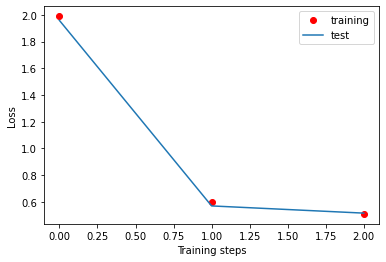

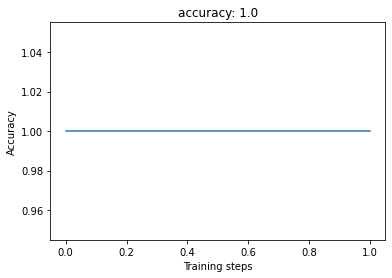

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses, 'ro')
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()